In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

system_settings = {
    "surface_name": "SrTiO3(001)",
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [6]:
# set attributes
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

# fix bulk atoms
from ase.constraints import FixAtoms

num_bulk_atoms = len(slab_batch)
bulk_indices = list(range(num_bulk_atoms))
surf_indices = slab.get_surface_atoms()
print(f"surface indices {surf_indices}")
fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

# c = FixAtoms(indices=fix_indices)
# slab_batch.set_constraint(c)

# set tags, so that we can identify the surface atoms
slab_batch.set_tags([1 if i in surf_indices else 0 for i in range(num_bulk_atoms)])

surface = SurfaceSystem(
    slab_batch, ads_positions, nff_surf_calc, system_settings=system_settings
)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

2024-05-21 22:18:29,437|INFO|initializing 64 virtual atoms
2024-05-21 22:18:29,463|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-05-21 22:18:29,464|INFO|number of pristine atoms is 60
2024-05-21 22:18:29,465|INFO|bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 15 16 17 18 19 20 21 24 25 26 27 28
 30 31 32 33 34 35 36 39 40 41 42 43 45 46 47 48 49 50 51 54 55 56 57 58]
2024-05-21 22:18:29,466|INFO|surface indices are [ 7  8 14 22 23 29 37 38 44 52 53 59]


surface indices [ 7  8 14 22 23 29 37 38 44 52 53 59]
fix indices [0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58]
      Step     Time          Energy         fmax
BFGS:    0 22:18:30     -467.521881        0.2306
BFGS:    1 22:18:30     -467.527832        0.1610
BFGS:    2 22:18:30     -467.533936        0.1001
BFGS:    3 22:18:31     -467.535400        0.1234
BFGS:    4 22:18:31     -467.539459        0.1376
BFGS:    5 22:18:31     -467.541412        0.0825
BFGS:    6 22:18:31     -467.542236        0.0278
BFGS:    7 22:18:31     -467.542328        0.0163
BFGS:    8 22:18:31     -467.542389        0.0149
BFGS:    9 22:18:31     -467.542389        0.0126
BFGS:   10 22:18:31     -467.542450        0.0158
BFGS:   11 22:18:31     -467.542480        0.0177
BFGS:   12 22:18:31     -467.542511        0.0134
BFGS:   13 22:18:31     -467.542511        0.0088


In [7]:
surface.get_potential_energy()

array([-467.543], dtype=float32)

In [8]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [9]:
surface.get_surface_energy()

array([12.469], dtype=float32)

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-05-21 22:18:33,605|INFO|there are 60 atoms in pristine slab
2024-05-21 22:18:33,607|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-05-21 22:18:33,608|INFO|In pristine slab, there are a total of 64 sites


      Step     Time          Energy         fmax
BFGS:    0 22:18:33     -467.521881        0.2306
BFGS:    1 22:18:33     -467.527832        0.1610
BFGS:    2 22:18:33     -467.533936        0.1001
BFGS:    3 22:18:33     -467.535400        0.1234
BFGS:    4 22:18:34     -467.539459        0.1376
BFGS:    5 22:18:34     -467.541412        0.0825
BFGS:    6 22:18:34     -467.542236        0.0278
BFGS:    7 22:18:34     -467.542328        0.0162
BFGS:    8 22:18:34     -467.542389        0.0149
BFGS:    9 22:18:34     -467.542389        0.0126
BFGS:   10 22:18:34     -467.542450        0.0158
BFGS:   11 22:18:34     -467.542480        0.0177
BFGS:   12 22:18:34     -467.542511        0.0133
BFGS:   13 22:18:34     -467.542511        0.0088


2024-05-21 22:18:34,950|INFO|running for 5 iterations per run over a total of 10 runs
2024-05-21 22:18:34,950|INFO|starting with iteration 0
2024-05-21 22:18:34,951|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 22:18:35     -470.895508        8.3718
BFGS:    1 22:18:35     -472.301514        3.7639
BFGS:    2 22:18:35     -473.146393        3.5143
BFGS:    3 22:18:35     -474.030487        3.1426
BFGS:    4 22:18:35     -474.421387        2.1212
BFGS:    5 22:18:35     -474.675568        1.4827
BFGS:    6 22:18:35     -474.987396        1.9972
BFGS:    7 22:18:35     -475.165131        1.3065
BFGS:    8 22:18:35     -475.489838        1.5823
BFGS:    9 22:18:35     -475.794708        2.5801
BFGS:   10 22:18:35     -476.260986        1.5222
BFGS:   11 22:18:35     -476.575684        1.7517
BFGS:   12 22:18:36     -476.877228        2.3799
BFGS:   13 22:18:36     -477.036652        2.6390
BFGS:   14 22:18:36     -477.223633        2.2080
BFGS:   15 22:18:36     -477.483917        1.7411
BFGS:   16 22:18:36     -477.635651        1.1657
BFGS:   17 22:18:36     -477.703735        0.8927
BFGS:

2024-05-21 22:18:36,788|INFO|Stated start ads is Ti
2024-05-21 22:18:36,788|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:18:36     -470.520477       10.5968
BFGS:    1 22:18:36     -472.101715        2.6206
BFGS:    2 22:18:37     -472.433258        1.9334
BFGS:    3 22:18:37     -472.740814        1.8444
BFGS:    4 22:18:37     -472.848785        1.6279
BFGS:    5 22:18:37     -472.996979        0.9382
BFGS:    6 22:18:37     -473.040985        0.7822
BFGS:    7 22:18:37     -473.129730        0.9132
BFGS:    8 22:18:37     -473.185211        0.8940
BFGS:    9 22:18:37     -473.266846        1.1333
BFGS:   10 22:18:37     -473.316681        1.0441
BFGS:   11 22:18:37     -473.414154        0.7844
BFGS:   12 22:18:37     -473.710693        1.5638
BFGS:   13 22:18:37     -473.996429        1.6246
BFGS:   14 22:18:38     -474.074219        4.1336
BFGS:   15 22:18:38     -474.319824        0.7948
BFGS:   16 22:18:38     -474.369476        0.7029
BFGS:   17 22:18:38     -474.499115        0.9936
BFGS:   18 22:18:38     -474.566071        0.7568
B

2024-05-21 22:18:38,626|INFO|Stated start ads is Ti
2024-05-21 22:18:38,627|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:18:38     -460.303925       30.9941
BFGS:    1 22:18:38     -466.915558        8.5976
BFGS:    2 22:18:38     -467.935059        5.3633
BFGS:    3 22:18:38     -468.798004        2.1277
BFGS:    4 22:18:39     -468.946442        1.5209
BFGS:    5 22:18:39     -469.098053        1.7248
BFGS:    6 22:18:39     -469.263184        1.3229
BFGS:    7 22:18:39     -469.324860        1.1692
BFGS:    8 22:18:39     -469.397797        0.6482
BFGS:    9 22:18:39     -469.438232        0.7798
BFGS:   10 22:18:39     -469.487671        0.8783
BFGS:   11 22:18:39     -469.528320        1.0481
BFGS:   12 22:18:39     -469.589081        0.8885
BFGS:   13 22:18:39     -469.632324        0.8542
BFGS:   14 22:18:39     -469.654938        0.4477
BFGS:   15 22:18:39     -469.668457        0.2599
BFGS:   16 22:18:40     -469.673431        0.2187
BFGS:   17 22:18:40     -469.676239        0.1357
BFGS:   18 22:18:40     -469.678589        0.1293
B

2024-05-21 22:18:40,505|INFO|Stated start ads is Sr
2024-05-21 22:18:40,506|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:18:40     -465.764984       26.6821
BFGS:    1 22:18:40     -469.788971        4.2246
BFGS:    2 22:18:40     -470.078125        2.7565
BFGS:    3 22:18:40     -470.550293        0.9523
BFGS:    4 22:18:40     -470.706421        1.3261
BFGS:    5 22:18:41     -470.850861        2.0079
BFGS:    6 22:18:41     -471.059235        2.3099
BFGS:    7 22:18:41     -471.302032        3.0304
BFGS:    8 22:18:41     -471.441010        1.6117
BFGS:    9 22:18:41     -471.472168        0.9917
BFGS:   10 22:18:41     -471.496582        0.5618
BFGS:   11 22:18:41     -471.505096        0.5655
BFGS:   12 22:18:41     -471.529388        0.7178
BFGS:   13 22:18:41     -471.639069        1.7002
BFGS:   14 22:18:41     -471.630280        3.3701
BFGS:   15 22:18:41     -471.763092        2.6046
BFGS:   16 22:18:41     -472.306396        2.8850
BFGS:   17 22:18:42     -472.626373        2.5728
BFGS:   18 22:18:42     -472.884399        2.0994
B

2024-05-21 22:18:42,374|INFO|Stated start ads is Ti
2024-05-21 22:18:42,374|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:18:42     -470.895599        8.3711
BFGS:    1 22:18:42     -472.301514        3.7640
BFGS:    2 22:18:42     -473.146484        3.5143
BFGS:    3 22:18:42     -474.030518        3.1425
BFGS:    4 22:18:42     -474.421356        2.1212
BFGS:    5 22:18:42     -474.675568        1.4826
BFGS:    6 22:18:42     -474.987335        1.9975
BFGS:    7 22:18:43     -475.165070        1.3065
BFGS:    8 22:18:43     -475.489746        1.5824
BFGS:    9 22:18:43     -475.794525        2.5803
BFGS:   10 22:18:43     -476.260834        1.5225
BFGS:   11 22:18:43     -476.575287        1.7501
BFGS:   12 22:18:43     -476.876953        2.3802
BFGS:   13 22:18:43     -477.036743        2.6369
BFGS:   14 22:18:43     -477.223633        2.2083
BFGS:   15 22:18:43     -477.484619        1.7411
BFGS:   16 22:18:43     -477.635834        1.1641
BFGS:   17 22:18:43     -477.703857        0.8927
BFGS:   18 22:18:43     -477.809662        1.4482
B

2024-05-21 22:18:44,221|INFO|Stated start ads is Ti
2024-05-21 22:18:44,222|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:18:44     -467.521881        0.2306
BFGS:    1 22:18:44     -467.527832        0.1610
BFGS:    2 22:18:44     -467.533936        0.1001
BFGS:    3 22:18:44     -467.535400        0.1234
BFGS:    4 22:18:44     -467.539459        0.1376
BFGS:    5 22:18:44     -467.541412        0.0825
BFGS:    6 22:18:44     -467.542236        0.0278
BFGS:    7 22:18:45     -467.542328        0.0162
BFGS:    8 22:18:45     -467.542389        0.0149
BFGS:    9 22:18:45     -467.542389        0.0126
BFGS:   10 22:18:45     -467.542450        0.0158
BFGS:   11 22:18:45     -467.542480        0.0177
BFGS:   12 22:18:45     -467.542511        0.0134
BFGS:   13 22:18:45     -467.542511        0.0088


2024-05-21 22:18:45,819|INFO|current energy is 12.46942138671875, calculated energy is 12.46942138671875
2024-05-21 22:18:45,820|INFO|optim structure has Energy = 12.469+/-0.314
2024-05-21 22:18:45,821|INFO|average force error = 0.029
2024-05-21 22:18:45,830|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:18:45     -449.987762       78.8524
BFGS:    1 22:18:46     -464.456177       14.0237
BFGS:    2 22:18:46     -465.404633        9.0810
BFGS:    3 22:18:46     -466.229706        1.6762
BFGS:    4 22:18:46     -466.349823        0.9406
BFGS:    5 22:18:46     -466.435303        1.2117
BFGS:    6 22:18:46     -466.653229        2.0948
BFGS:    7 22:18:46     -467.042267        2.4886
BFGS:    8 22:18:46     -467.167816        2.3739
BFGS:    9 22:18:46     -467.307404        1.8715
BFGS:   10 22:18:46     -467.477570        1.7200
BFGS:   11 22:18:46     -467.773102        2.7908
BFGS:   12 22:18:47     -467.908569        2.7817
BFGS:   13 22:18:47     -468.480194        2.6309
BFGS:   14 22:18:47     -468.662445        2.5414
BFGS:   15 22:18:47     -468.803497        2.1584
BFGS:   16 22:18:47     -468.940186        1.9040
BFGS:   17 22:18:47     -469.016693        1.5314
BFGS:   18 22:18:47     -469.098999        0.9286
B

2024-05-21 22:18:47,814|INFO|Stated start ads is Sr
2024-05-21 22:18:47,814|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:18:47     -463.266479       20.3172
BFGS:    1 22:18:48     -467.745117        5.7969
BFGS:    2 22:18:48     -468.463531        4.0458
BFGS:    3 22:18:48     -468.946442        2.5557
BFGS:    4 22:18:48     -469.048004        1.3239
BFGS:    5 22:18:48     -469.256256        1.2310
BFGS:    6 22:18:48     -469.387360        1.3744
BFGS:    7 22:18:48     -469.460297        1.1752
BFGS:    8 22:18:48     -469.559937        0.6043
BFGS:    9 22:18:48     -469.586273        0.4071
BFGS:   10 22:18:48     -469.611725        0.4969
BFGS:   11 22:18:48     -469.629395        0.6143
BFGS:   12 22:18:48     -469.648102        0.4221
BFGS:   13 22:18:49     -469.656708        0.1846
BFGS:   14 22:18:49     -469.661530        0.1477
BFGS:   15 22:18:49     -469.664093        0.1629
BFGS:   16 22:18:49     -469.666382        0.1519
BFGS:   17 22:18:49     -469.668060        0.1466
BFGS:   18 22:18:49     -469.669464        0.1555
B

2024-05-21 22:18:49,694|INFO|Stated start ads is Sr
2024-05-21 22:18:49,695|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:18:49     -469.088867        2.7070
BFGS:    1 22:18:49     -469.377106        3.4408
BFGS:    2 22:18:49     -470.342407        3.5276
BFGS:    3 22:18:50     -470.473755        3.5316
BFGS:    4 22:18:50     -470.806061        2.1484
BFGS:    5 22:18:50     -470.870850        1.9382
BFGS:    6 22:18:50     -471.044464        1.5869
BFGS:    7 22:18:50     -471.125977        1.4587
BFGS:    8 22:18:50     -471.266113        1.3669
BFGS:    9 22:18:50     -471.345123        1.5125
BFGS:   10 22:18:50     -471.395111        1.5731
BFGS:   11 22:18:50     -471.431671        1.5060
BFGS:   12 22:18:50     -471.471344        1.3243
BFGS:   13 22:18:51     -471.515137        1.2913
BFGS:   14 22:18:51     -471.551422        1.1142
BFGS:   15 22:18:51     -471.574371        1.3058
BFGS:   16 22:18:51     -471.589478        1.2985
BFGS:   17 22:18:51     -471.610016        1.4430
BFGS:   18 22:18:51     -471.636932        1.4542
B

2024-05-21 22:18:51,796|INFO|Stated start ads is O
2024-05-21 22:18:51,797|INFO|Actual start ads is O


      Step     Time          Energy         fmax
BFGS:    0 22:18:51     -465.896942       13.8634
BFGS:    1 22:18:52     -469.168701        5.0805
BFGS:    2 22:18:52     -469.753998        2.3377
BFGS:    3 22:18:52     -469.987152        1.6738
BFGS:    4 22:18:52     -470.177002        1.2926
BFGS:    5 22:18:52     -470.338135        1.3733
BFGS:    6 22:18:52     -470.560059        1.3645
BFGS:    7 22:18:52     -470.761719        2.3687
BFGS:    8 22:18:52     -471.089325        3.0382
BFGS:    9 22:18:52     -471.267822        1.4863
BFGS:   10 22:18:52     -471.385956        1.2749
BFGS:   11 22:18:52     -471.680176        0.6695
BFGS:   12 22:18:53     -471.761810        0.8461
BFGS:   13 22:18:53     -471.794891        0.4523
BFGS:   14 22:18:53     -471.817993        0.3765
BFGS:   15 22:18:53     -471.831299        0.3134
BFGS:   16 22:18:53     -471.846649        0.3364
BFGS:   17 22:18:53     -471.858246        0.3080
BFGS:   18 22:18:53     -471.865021        0.2117
B

2024-05-21 22:18:57,736|INFO|current energy is 13.137603759765625, calculated energy is 13.137603759765625
2024-05-21 22:18:57,736|INFO|optim structure has Energy = 13.138+/-0.603
2024-05-21 22:18:57,738|INFO|average force error = 0.069
2024-05-21 22:18:57,747|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:18:57     -460.945648       20.6984
BFGS:    1 22:18:57     -468.289948        8.5672
BFGS:    2 22:18:58     -471.211823        4.5484
BFGS:    3 22:18:58     -472.539886        2.5658
BFGS:    4 22:18:58     -473.374603        2.8497
BFGS:    5 22:18:58     -473.968475        2.3455
BFGS:    6 22:18:58     -474.434906        1.7754
BFGS:    7 22:18:58     -474.874847        2.8143
BFGS:    8 22:18:58     -475.299683        2.4333
BFGS:    9 22:18:58     -476.046844        2.5993
BFGS:   10 22:18:58     -476.599518        3.0001
BFGS:   11 22:18:58     -477.167633        2.3915
BFGS:   12 22:18:58     -477.546631        3.6036
BFGS:   13 22:18:58     -477.992218        1.9790
BFGS:   14 22:18:59     -478.279022        1.5189
BFGS:   15 22:18:59     -478.935211        1.7875
BFGS:   16 22:18:59     -479.413177        2.2078
BFGS:   17 22:18:59     -479.856110        2.2481
BFGS:   18 22:18:59     -480.358154        2.1512
B

2024-05-21 22:19:01,509|INFO|Stated start ads is O
2024-05-21 22:19:01,510|INFO|Actual start ads is O


      Step     Time          Energy         fmax
BFGS:    0 22:19:01     -463.088104       21.6783
BFGS:    1 22:19:01     -473.318024       11.5483
BFGS:    2 22:19:01     -477.385223        5.6954
BFGS:    3 22:19:01     -479.482513        3.1897
BFGS:    4 22:19:01     -480.836517        2.8029
BFGS:    5 22:19:02     -481.710785        2.8055
BFGS:    6 22:19:02     -482.229370        2.1799
BFGS:    7 22:19:02     -482.760376        1.8848
BFGS:    8 22:19:02     -483.118561        1.5301
BFGS:    9 22:19:02     -483.574127        1.6707
BFGS:   10 22:19:02     -483.791718        1.8222
BFGS:   11 22:19:02     -484.094971        1.3343
BFGS:   12 22:19:02     -484.234467        1.3967
BFGS:   13 22:19:02     -484.519043        1.5528
BFGS:   14 22:19:02     -484.933685        1.9623
BFGS:   15 22:19:02     -485.356934        2.5188
BFGS:   16 22:19:02     -485.708099        3.2551
BFGS:   17 22:19:03     -485.988251        3.8987
BFGS:   18 22:19:03     -486.318878        4.1668
B

2024-05-21 22:19:05,313|INFO|Stated start ads is Sr
2024-05-21 22:19:05,314|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:05     -466.399414       22.1769
BFGS:    1 22:19:05     -477.018555       12.0972
BFGS:    2 22:19:05     -481.490692        6.4891
BFGS:    3 22:19:05     -483.947021        3.8650
BFGS:    4 22:19:05     -485.567841        2.7733
BFGS:    5 22:19:05     -486.759155        2.9909
BFGS:    6 22:19:05     -487.629974        2.2766
BFGS:    7 22:19:06     -488.267090        2.0058
BFGS:    8 22:19:06     -488.837250        1.6017
BFGS:    9 22:19:06     -489.378754        1.4621
BFGS:   10 22:19:06     -489.733887        1.2586
BFGS:   11 22:19:06     -489.966156        1.2547
BFGS:   12 22:19:06     -490.163788        1.1840
BFGS:   13 22:19:06     -490.292816        1.1575
BFGS:   14 22:19:06     -490.503906        1.1718
BFGS:   15 22:19:06     -490.761230        1.4670
BFGS:   16 22:19:06     -490.996094        1.8681
BFGS:   17 22:19:06     -491.362030        2.0625
BFGS:   18 22:19:06     -491.697266        2.1735
B

2024-05-21 22:19:09,180|INFO|current energy is 9.42523193359375, calculated energy is 9.42523193359375
2024-05-21 22:19:09,180|INFO|optim structure has Energy = 9.425+/-0.359
2024-05-21 22:19:09,181|INFO|average force error = 0.080
2024-05-21 22:19:09,191|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:19:09     -452.137848       50.2133
BFGS:    1 22:19:09     -470.517426       16.4126
BFGS:    2 22:19:09     -481.598358       10.3206
BFGS:    3 22:19:09     -486.707367        5.2410
BFGS:    4 22:19:09     -489.823944        3.2751
BFGS:    5 22:19:09     -491.802338        3.3007
BFGS:    6 22:19:09     -493.180084        2.3040
BFGS:    7 22:19:09     -494.197540        2.6218
BFGS:    8 22:19:10     -495.005615        2.3725
BFGS:    9 22:19:10     -496.038788        2.1917
BFGS:   10 22:19:10     -496.665527        2.6367
BFGS:   11 22:19:10     -497.365997        2.6887
BFGS:   12 22:19:10     -498.137054        2.0747
BFGS:   13 22:19:10     -498.640717        2.1934
BFGS:   14 22:19:10     -499.001678        1.5836
BFGS:   15 22:19:10     -499.342285        1.1252
BFGS:   16 22:19:10     -499.601349        1.3830
BFGS:   17 22:19:10     -499.797821        1.2135
BFGS:   18 22:19:10     -499.968628        0.9776
B

2024-05-21 22:19:13,114|INFO|Stated start ads is Sr
2024-05-21 22:19:13,115|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:13     -414.137115      100.4045
BFGS:    1 22:19:13     -439.752899       29.6956
BFGS:    2 22:19:13     -459.327972       32.9889
BFGS:    3 22:19:13     -478.188080       30.0490
BFGS:    4 22:19:13     -486.963470       18.0692
BFGS:    5 22:19:13     -493.291962        6.0989
BFGS:    6 22:19:13     -496.937378        3.4291
BFGS:    7 22:19:13     -498.882812        2.5073
BFGS:    8 22:19:14     -500.057343        2.9280
BFGS:    9 22:19:14     -501.098846        2.9892
BFGS:   10 22:19:14     -502.287994        2.8588
BFGS:   11 22:19:14     -503.009369        2.2916
BFGS:   12 22:19:14     -503.888092        2.0606
BFGS:   13 22:19:14     -504.530426        2.6537
BFGS:   14 22:19:14     -505.193939        2.6091
BFGS:   15 22:19:14     -505.586182        1.7266
BFGS:   16 22:19:14     -505.942535        1.4676
BFGS:   17 22:19:14     -506.286377        1.3617
BFGS:   18 22:19:14     -506.545654        1.3184
B

2024-05-21 22:19:19,124|INFO|Stated start ads is Ti
2024-05-21 22:19:19,125|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:19:19     -418.355835      100.0429
BFGS:    1 22:19:19     -444.738678       31.3642
BFGS:    2 22:19:19     -465.931488       53.2977
BFGS:    3 22:19:19     -482.706879       26.8101
BFGS:    4 22:19:19     -493.650848       12.3112
BFGS:    5 22:19:19     -499.839355        5.8710
BFGS:    6 22:19:19     -502.691193        3.1909
BFGS:    7 22:19:19     -504.109253        2.0442
BFGS:    8 22:19:19     -505.103912        2.9136
BFGS:    9 22:19:19     -506.092773        3.4315
BFGS:   10 22:19:20     -506.983765        3.0549
BFGS:   11 22:19:20     -507.933502        2.3952
BFGS:   12 22:19:20     -508.712311        2.4277
BFGS:   13 22:19:20     -509.760254        3.0680
BFGS:   14 22:19:20     -510.249725        2.7123
BFGS:   15 22:19:20     -510.738525        1.6462
BFGS:   16 22:19:20     -511.161957        1.4595
BFGS:   17 22:19:20     -511.369720        1.3635
BFGS:   18 22:19:20     -511.581909        1.3893
B

2024-05-21 22:19:21,070|INFO|current energy is 1.89056396484375, calculated energy is 1.89056396484375
2024-05-21 22:19:21,071|INFO|optim structure has Energy = 1.891+/-0.335
2024-05-21 22:19:21,071|INFO|average force error = 0.082
2024-05-21 22:19:21,081|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:19:21     -419.246552      101.0368
BFGS:    1 22:19:21     -445.056122       32.7260
BFGS:    2 22:19:21     -468.266815       58.6839
BFGS:    3 22:19:21     -484.083496       32.8796
BFGS:    4 22:19:21     -495.494843       13.4396
BFGS:    5 22:19:21     -502.127045        6.1851
BFGS:    6 22:19:21     -505.847137        2.6191
BFGS:    7 22:19:21     -507.053802        1.9186
BFGS:    8 22:19:21     -507.964630        2.2132
BFGS:    9 22:19:22     -508.793579        2.4719
BFGS:   10 22:19:22     -509.451508        2.2270
BFGS:   11 22:19:22     -510.081696        1.5299
BFGS:   12 22:19:22     -510.512726        1.3927
BFGS:   13 22:19:22     -510.925690        1.1588
BFGS:   14 22:19:22     -511.217285        1.8563
BFGS:   15 22:19:22     -511.446136        1.6344
BFGS:   16 22:19:22     -511.967926        1.0662
BFGS:   17 22:19:22     -512.141602        1.0908
BFGS:   18 22:19:22     -512.372742        0.9897
B

2024-05-21 22:19:23,077|INFO|Stated start ads is Sr
2024-05-21 22:19:23,077|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:23     -420.124237       98.9154
BFGS:    1 22:19:23     -449.562256       32.9829
BFGS:    2 22:19:23     -474.583496       52.4130
BFGS:    3 22:19:23     -488.481110       32.7390
BFGS:    4 22:19:23     -499.634033       10.4693
BFGS:    5 22:19:23     -505.893219        6.0540
BFGS:    6 22:19:23     -509.234894        4.2253
BFGS:    7 22:19:23     -510.911835        4.2960
BFGS:    8 22:19:23     -512.187988        3.6210
BFGS:    9 22:19:23     -513.408569        4.1578
BFGS:   10 22:19:24     -514.724365        3.3208
BFGS:   11 22:19:24     -515.381531        2.9835
BFGS:   12 22:19:24     -515.882202        2.4406
BFGS:   13 22:19:24     -516.627441        1.9088
BFGS:   14 22:19:24     -517.054016        1.5591
BFGS:   15 22:19:24     -517.342102        1.3040
BFGS:   16 22:19:24     -517.711914        1.2262
BFGS:   17 22:19:24     -517.975281        1.3662
BFGS:   18 22:19:24     -518.286499        1.8171
B

2024-05-21 22:19:24,973|INFO|Stated start ads is Ti
2024-05-21 22:19:24,974|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:19:25     -377.809967       97.5836
BFGS:    1 22:19:25     -356.946686     1143.0868
BFGS:    2 22:19:25     -430.175903      362.9838
BFGS:    3 22:19:25     -452.451508      196.9143
BFGS:    4 22:19:25     -466.186859       16.3780
BFGS:    5 22:19:25     -477.070099       28.0140
BFGS:    6 22:19:25     -482.401001       13.6488
BFGS:    7 22:19:25     -485.780273        5.0620
BFGS:    8 22:19:25     -487.854828       15.2386
BFGS:    9 22:19:25     -489.191254        9.2304
BFGS:   10 22:19:25     -490.129639        6.4134
BFGS:   11 22:19:25     -490.962646       14.6137
BFGS:   12 22:19:26     -491.717621        4.0258
BFGS:   13 22:19:26     -492.748627        2.8586
BFGS:   14 22:19:26     -493.299408        3.5819
BFGS:   15 22:19:26     -494.159180        8.6311
BFGS:   16 22:19:26     -494.619415       40.2677
BFGS:   17 22:19:26     -494.819824       30.9891
BFGS:   18 22:19:26     -495.548096       16.5930
B

2024-05-21 22:19:26,801|INFO|Stated start ads is Sr
2024-05-21 22:19:26,802|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:26     -407.479523       96.8342
BFGS:    1 22:19:26     -434.586456       49.0977
BFGS:    2 22:19:27     -456.772430       54.1871
BFGS:    3 22:19:27     -474.976929       42.7696
BFGS:    4 22:19:27     -489.057037       18.3940
BFGS:    5 22:19:27     -498.698730       11.5887
BFGS:    6 22:19:27     -503.938629        5.6665
BFGS:    7 22:19:27     -506.641754        2.1907
BFGS:    8 22:19:27     -507.359283        2.4682
BFGS:    9 22:19:27     -508.459381        1.7884
BFGS:   10 22:19:27     -509.104767        2.2509
BFGS:   11 22:19:27     -509.691986        2.3799
BFGS:   12 22:19:27     -510.659332        2.8808
BFGS:   13 22:19:28     -511.239349        2.7736
BFGS:   14 22:19:28     -511.997467        1.6069
BFGS:   15 22:19:28     -512.422607        1.4331
BFGS:   16 22:19:28     -512.944885        1.4181
BFGS:   17 22:19:28     -513.395325        1.7152
BFGS:   18 22:19:28     -513.725159        1.8627
B

2024-05-21 22:19:28,673|INFO|Stated start ads is O
2024-05-21 22:19:28,674|INFO|Actual start ads is O


      Step     Time          Energy         fmax
BFGS:    0 22:19:28     -399.705322       99.1253
BFGS:    1 22:19:28     -429.863159       29.4953
BFGS:    2 22:19:28     -451.888763       52.3459
BFGS:    3 22:19:29     -457.060913      251.7930
BFGS:    4 22:19:29     -469.827118       59.1408
BFGS:    5 22:19:29     -474.559204       16.2680
BFGS:    6 22:19:29     -479.362762       12.3195
BFGS:    7 22:19:29     -482.322235        9.8754
BFGS:    8 22:19:29     -483.775482       19.8153
BFGS:    9 22:19:29     -484.519989       25.2205
BFGS:   10 22:19:29     -485.165314        6.0936
BFGS:   11 22:19:29     -485.988495       12.8082
BFGS:   12 22:19:29     -486.492432        9.5732
BFGS:   13 22:19:29     -486.974030        3.5874
BFGS:   14 22:19:30     -487.455444        3.3228
BFGS:   15 22:19:30     -487.810211        2.8999
BFGS:   16 22:19:30     -488.118011        2.5213
BFGS:   17 22:19:30     -488.469391        4.3112
BFGS:   18 22:19:30     -488.981537       12.2532
B

2024-05-21 22:19:30,657|INFO|Stated start ads is Sr
2024-05-21 22:19:30,658|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:30     -418.355804      100.0429
BFGS:    1 22:19:30     -444.738678       31.3643
BFGS:    2 22:19:30     -465.931641       53.2983
BFGS:    3 22:19:31     -482.706879       26.8103
BFGS:    4 22:19:31     -493.650848       12.3113
BFGS:    5 22:19:31     -499.839355        5.8709
BFGS:    6 22:19:31     -502.691193        3.1909
BFGS:    7 22:19:31     -504.109253        2.0442
BFGS:    8 22:19:31     -505.103912        2.9136
BFGS:    9 22:19:31     -506.092682        3.4315
BFGS:   10 22:19:31     -506.983765        3.0549
BFGS:   11 22:19:31     -507.933502        2.3952
BFGS:   12 22:19:31     -508.712311        2.4277
BFGS:   13 22:19:31     -509.760223        3.0681
BFGS:   14 22:19:31     -510.249664        2.7123
BFGS:   15 22:19:31     -510.738525        1.6462
BFGS:   16 22:19:32     -511.161957        1.4595
BFGS:   17 22:19:32     -511.369659        1.3635
BFGS:   18 22:19:32     -511.581909        1.3894
B

2024-05-21 22:19:32,622|INFO|current energy is 1.89056396484375, calculated energy is 1.89056396484375
2024-05-21 22:19:32,623|INFO|optim structure has Energy = 1.891+/-0.335
2024-05-21 22:19:32,623|INFO|average force error = 0.082
2024-05-21 22:19:32,633|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:19:32      129.956711     9074.9717
BFGS:    1 22:19:32     -369.702240      253.4158
BFGS:    2 22:19:32     -401.860352      199.6967
BFGS:    3 22:19:33     -419.357208      390.0240
BFGS:    4 22:19:33     -226.875351     3539.6624
BFGS:    5 22:19:33     -415.021088      608.3232
BFGS:    6 22:19:33     -449.290375      207.2596
BFGS:    7 22:19:33     -454.634064      195.9210
BFGS:    8 22:19:33     -465.586029      194.1505
BFGS:    9 22:19:33     -472.426422      161.9856
BFGS:   10 22:19:33     -476.736420       83.0292
BFGS:   11 22:19:33     -479.877045       31.2827
BFGS:   12 22:19:33     -480.858032       37.1561
BFGS:   13 22:19:33     -482.541138       12.2742
BFGS:   14 22:19:33     -483.760010        5.0084
BFGS:   15 22:19:34     -484.634003       21.1602
BFGS:   16 22:19:34     -485.427368       17.7137
BFGS:   17 22:19:34     -486.726074       10.5624
BFGS:   18 22:19:34     -487.278473       21.0338
B

2024-05-21 22:19:34,533|INFO|Stated start ads is Ti
2024-05-21 22:19:34,534|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:19:34     -411.547516       99.9110
BFGS:    1 22:19:34     -439.577484       28.9242
BFGS:    2 22:19:34     -461.879608       35.8857
BFGS:    3 22:19:34     -480.894653       23.8448
BFGS:    4 22:19:34     -491.175385       13.3528
BFGS:    5 22:19:35     -497.239014        5.2073
BFGS:    6 22:19:35     -500.061371        3.8113
BFGS:    7 22:19:35     -502.082733        3.6379
BFGS:    8 22:19:35     -503.678131        3.4308
BFGS:    9 22:19:35     -505.067535        4.2254
BFGS:   10 22:19:35     -506.669525        3.9022
BFGS:   11 22:19:35     -507.873444        3.0781
BFGS:   12 22:19:35     -508.786987        2.5244
BFGS:   13 22:19:35     -509.683746        2.0944
BFGS:   14 22:19:35     -510.308258        1.8092
BFGS:   15 22:19:35     -510.641235        1.5777
BFGS:   16 22:19:35     -511.002472        1.1755
BFGS:   17 22:19:36     -511.190460        0.9089
BFGS:   18 22:19:36     -511.349823        1.0672
B

2024-05-21 22:19:36,354|INFO|Stated start ads is Sr
2024-05-21 22:19:36,355|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:36     -422.626617       99.8226
BFGS:    1 22:19:36     -449.581696       32.5655
BFGS:    2 22:19:36     -472.455475       55.8883
BFGS:    3 22:19:36     -489.131744       26.2353
BFGS:    4 22:19:36     -499.979858       12.3369
BFGS:    5 22:19:36     -506.486908        6.2256
BFGS:    6 22:19:36     -510.110565        3.2374
BFGS:    7 22:19:37     -511.572876        2.5572
BFGS:    8 22:19:37     -512.764587        2.3143
BFGS:    9 22:19:37     -513.778931        3.1625
BFGS:   10 22:19:37     -514.803040        3.7164
BFGS:   11 22:19:37     -515.501709        2.4437
BFGS:   12 22:19:37     -516.132141        1.7959
BFGS:   13 22:19:37     -516.746643        1.6555
BFGS:   14 22:19:37     -517.121704        2.2467
BFGS:   15 22:19:37     -517.599060        1.7764
BFGS:   16 22:19:37     -518.103638        2.0715
BFGS:   17 22:19:37     -518.476990        1.5423
BFGS:   18 22:19:38     -518.714355        1.2638
B

2024-05-21 22:19:40,377|INFO|Stated start ads is Sr
2024-05-21 22:19:40,378|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:40     -421.952545       98.6638
BFGS:    1 22:19:40     -446.388458       29.4342
BFGS:    2 22:19:40     -478.198761       36.9829
BFGS:    3 22:19:40     -295.011597     3168.7766
BFGS:    4 22:19:40     -479.529633      269.8195
BFGS:    5 22:19:40     -486.390472       65.6435
BFGS:    6 22:19:40     -494.270844       47.8333
BFGS:    7 22:19:41     -494.842285      142.4558
BFGS:    8 22:19:41     -499.331390       31.9481
BFGS:    9 22:19:41     -501.027985        5.4515
BFGS:   10 22:19:41     -502.695801       13.9541
BFGS:   11 22:19:41     -503.893799       13.5772
BFGS:   12 22:19:41     -504.957275        5.8695
BFGS:   13 22:19:41     -506.198578        4.0644
BFGS:   14 22:19:41     -506.903778        9.1684
BFGS:   15 22:19:41     -507.361176        9.4636
BFGS:   16 22:19:41     -507.849518        4.0127
BFGS:   17 22:19:41     -508.115082        8.8029
BFGS:   18 22:19:41     -508.354492        4.9145
B

2024-05-21 22:19:42,231|INFO|Stated start ads is Ti
2024-05-21 22:19:42,232|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:19:42     -422.626617       99.8226
BFGS:    1 22:19:42     -449.581696       32.5655
BFGS:    2 22:19:42     -472.455353       55.8882
BFGS:    3 22:19:42     -489.131744       26.2351
BFGS:    4 22:19:42     -499.979858       12.3369
BFGS:    5 22:19:42     -506.486938        6.2256
BFGS:    6 22:19:42     -510.110504        3.2374
BFGS:    7 22:19:42     -511.572906        2.5573
BFGS:    8 22:19:42     -512.764587        2.3143
BFGS:    9 22:19:43     -513.778931        3.1625
BFGS:   10 22:19:43     -514.803040        3.7164
BFGS:   11 22:19:43     -515.501709        2.4436
BFGS:   12 22:19:43     -516.132263        1.7959
BFGS:   13 22:19:43     -516.746643        1.6555
BFGS:   14 22:19:43     -517.121643        2.2466
BFGS:   15 22:19:43     -517.599060        1.7764
BFGS:   16 22:19:43     -518.103638        2.0715
BFGS:   17 22:19:43     -518.476990        1.5423
BFGS:   18 22:19:43     -518.714294        1.2638
B

2024-05-21 22:19:44,199|INFO|current energy is -0.5618896484375, calculated energy is -0.5618896484375
2024-05-21 22:19:44,200|INFO|optim structure has Energy = -0.562+/-0.356
2024-05-21 22:19:44,200|INFO|average force error = 0.085
2024-05-21 22:19:44,209|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:19:44     -426.400116       98.6092
BFGS:    1 22:19:44     -453.646515       33.1947
BFGS:    2 22:19:44     -479.381927       54.9882
BFGS:    3 22:19:44     -496.129547       27.6094
BFGS:    4 22:19:44     -508.925140       12.4489
BFGS:    5 22:19:44     -516.115906        6.8378
BFGS:    6 22:19:44     -520.600647        3.3846
BFGS:    7 22:19:44     -522.177246        2.3332
BFGS:    8 22:19:44     -523.297668        2.2356
BFGS:    9 22:19:45     -524.509521        3.9271
BFGS:   10 22:19:45     -525.555115        4.4326
BFGS:   11 22:19:45     -526.695496        2.7257
BFGS:   12 22:19:45     -527.347351        1.8526
BFGS:   13 22:19:45     -528.087036        1.5419
BFGS:   14 22:19:45     -528.515198        1.7368
BFGS:   15 22:19:45     -528.956726        2.1276
BFGS:   16 22:19:45     -529.397156        1.6931
BFGS:   17 22:19:45     -529.944092        1.3774
BFGS:   18 22:19:45     -530.411682        3.0573
B

2024-05-21 22:19:45,933|INFO|Stated start ads is Ti
2024-05-21 22:19:45,934|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:19:46     -349.340118      627.9953
BFGS:    1 22:19:46     -295.465820     1155.2225
BFGS:    2 22:19:46     -377.735016      294.3158
BFGS:    3 22:19:46     -410.805176      267.9558
BFGS:    4 22:19:46     -413.009918      373.7758
BFGS:    5 22:19:46     -403.722290      160.3412
BFGS:    6 22:19:46     -432.417236      117.1986
BFGS:    7 22:19:46     -461.761200      197.3311
BFGS:    8 22:19:46     -468.208344      130.7266
BFGS:    9 22:19:46     -483.987701       59.9830
BFGS:   10 22:19:46     -489.739655       88.0801
BFGS:   11 22:19:47     -494.515228        9.3533
BFGS:   12 22:19:47     -496.166046       14.5708
BFGS:   13 22:19:47     -498.876465       41.2999
BFGS:   14 22:19:47     -501.105103       15.3824
BFGS:   15 22:19:47     -502.830902       11.4880
BFGS:   16 22:19:47     -504.064240       21.4867
BFGS:   17 22:19:47     -505.177490       61.1411
BFGS:   18 22:19:47     -506.220428       40.5774
B

2024-05-21 22:19:47,882|INFO|Stated start ads is Ti
2024-05-21 22:19:47,882|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:19:47     -432.922455      100.9928
BFGS:    1 22:19:48     -459.433838       34.1423
BFGS:    2 22:19:48     -479.695648       54.0843
BFGS:    3 22:19:48     -496.982758       23.1757
BFGS:    4 22:19:48     -508.244720       10.6860
BFGS:    5 22:19:48     -514.301208        5.3508
BFGS:    6 22:19:48     -517.796814        3.1026
BFGS:    7 22:19:48     -519.319092        3.3785
BFGS:    8 22:19:48     -520.364075        2.3278
BFGS:    9 22:19:48     -521.358398        2.4570
BFGS:   10 22:19:48     -522.155701        3.2868
BFGS:   11 22:19:48     -522.867676        2.5970
BFGS:   12 22:19:49     -523.440369        1.8632
BFGS:   13 22:19:49     -524.038269        2.0778
BFGS:   14 22:19:49     -524.479065        2.1679
BFGS:   15 22:19:49     -524.474060        8.3604
BFGS:   16 22:19:49     -525.312439        2.6646
BFGS:   17 22:19:49     -525.729065        2.0209
BFGS:   18 22:19:49     -526.112732        1.6450
B

2024-05-21 22:19:49,804|INFO|Stated start ads is Ti
2024-05-21 22:19:49,805|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:19:49     -433.321869       98.3096
BFGS:    1 22:19:50     -460.441650       47.5152
BFGS:    2 22:19:50     -480.500641       34.3864
BFGS:    3 22:19:50     -495.234863       20.9570
BFGS:    4 22:19:50     -504.684235       10.7372
BFGS:    5 22:19:50     -509.451752        6.4598
BFGS:    6 22:19:50     -512.587952        4.7156
BFGS:    7 22:19:50     -514.539551        3.3241
BFGS:    8 22:19:50     -515.898865        2.6508
BFGS:    9 22:19:50     -516.827209        2.5338
BFGS:   10 22:19:50     -518.050781        1.6843
BFGS:   11 22:19:50     -518.551514        1.8126
BFGS:   12 22:19:50     -519.093323        1.5869
BFGS:   13 22:19:50     -519.384460        2.5630
BFGS:   14 22:19:51     -519.719543        1.2376
BFGS:   15 22:19:51     -519.936340        1.2354
BFGS:   16 22:19:51     -520.091675        1.2577
BFGS:   17 22:19:51     -520.212830        1.1509
BFGS:   18 22:19:51     -520.349304        1.0463
B

2024-05-21 22:19:53,472|INFO|Stated start ads is O
2024-05-21 22:19:53,472|INFO|Actual start ads is O


      Step     Time          Energy         fmax
BFGS:    0 22:19:53     -433.321869       98.3096
BFGS:    1 22:19:53     -460.441650       47.5152
BFGS:    2 22:19:53     -480.500641       34.3864
BFGS:    3 22:19:53     -495.234863       20.9570
BFGS:    4 22:19:53     -504.684235       10.7372
BFGS:    5 22:19:54     -509.451752        6.4598
BFGS:    6 22:19:54     -512.587952        4.7156
BFGS:    7 22:19:54     -514.539551        3.3241
BFGS:    8 22:19:54     -515.898865        2.6508
BFGS:    9 22:19:54     -516.827209        2.5338
BFGS:   10 22:19:54     -518.050781        1.6843
BFGS:   11 22:19:54     -518.551514        1.8126
BFGS:   12 22:19:54     -519.093323        1.5869
BFGS:   13 22:19:54     -519.384460        2.5630
BFGS:   14 22:19:54     -519.719543        1.2376
BFGS:   15 22:19:54     -519.936340        1.2354
BFGS:   16 22:19:54     -520.091675        1.2577
BFGS:   17 22:19:55     -520.212830        1.1509
BFGS:   18 22:19:55     -520.349304        1.0462
B

2024-05-21 22:19:55,385|INFO|current energy is -0.6441650390625, calculated energy is -0.64422607421875
2024-05-21 22:19:55,386|INFO|optim structure has Energy = -0.644+/-0.184
2024-05-21 22:19:55,387|INFO|average force error = 0.063
2024-05-21 22:19:55,395|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:19:55      115.384338     9104.5984
BFGS:    1 22:19:55     -404.957184      115.6873
BFGS:    2 22:19:55     -440.754395       83.9945
BFGS:    3 22:19:55     -464.057587       72.2889
BFGS:    4 22:19:55     -478.230255       69.2826
BFGS:    5 22:19:55     -491.753510       67.5416
BFGS:    6 22:19:56     -500.092621       59.3136
BFGS:    7 22:19:56     -504.213104       53.8762
BFGS:    8 22:19:56     -506.697540       44.9952
BFGS:    9 22:19:56     -508.598541       33.7502
BFGS:   10 22:19:56     -509.960175       20.9211
BFGS:   11 22:19:56     -510.983002       18.4770
BFGS:   12 22:19:56     -512.639099       11.0115
BFGS:   13 22:19:56     -513.073669        5.4031
BFGS:   14 22:19:56     -513.443176        7.3598
BFGS:   15 22:19:56     -513.786133        8.2443
BFGS:   16 22:19:56     -513.957214        1.3700
BFGS:   17 22:19:56     -514.157654        5.7635
BFGS:   18 22:19:56     -514.336975        4.8237
B

2024-05-21 22:19:57,199|INFO|Stated start ads is Sr
2024-05-21 22:19:57,200|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:19:57     -436.040131       98.3662
BFGS:    1 22:19:57     -461.075806       47.9906
BFGS:    2 22:19:57     -476.746979       33.9980
BFGS:    3 22:19:57     -488.637177       20.5957
BFGS:    4 22:19:57     -496.842194       10.6854
BFGS:    5 22:19:57     -501.078857        5.5822
BFGS:    6 22:19:57     -503.939056        5.5119
BFGS:    7 22:19:57     -505.826904        4.1772
BFGS:    8 22:19:58     -506.890289        2.0241
BFGS:    9 22:19:58     -507.431732        1.7527
BFGS:   10 22:19:58     -508.404053        1.7363
BFGS:   11 22:19:58     -508.764984        1.9320
BFGS:   12 22:19:58     -509.150604        1.5206
BFGS:   13 22:19:58     -509.431793        1.3392
BFGS:   14 22:19:58     -509.762054        1.6913
BFGS:   15 22:19:58     -509.978851        1.8308
BFGS:   16 22:19:58     -510.235931        1.4062
BFGS:   17 22:19:58     -510.409027        0.9064
BFGS:   18 22:19:58     -510.495728        0.9073
B

2024-05-21 22:20:00,834|INFO|Stated start ads is Ti
2024-05-21 22:20:00,835|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:20:00     -422.514648      137.9623
BFGS:    1 22:20:01     -450.593262       81.7168
BFGS:    2 22:20:01       73.158592     9410.6446
BFGS:    3 22:20:01     -417.878754     1202.8701
BFGS:    4 22:20:01     -483.534546       43.7852
BFGS:    5 22:20:01     -493.179565       16.2379
BFGS:    6 22:20:01     -498.949493        9.8436
BFGS:    7 22:20:01     -503.377197       13.1737
BFGS:    8 22:20:01     -506.215576        3.4835
BFGS:    9 22:20:01     -507.761627        2.9111
BFGS:   10 22:20:01     -509.066925        3.7587
BFGS:   11 22:20:01     -510.668945        3.3485
BFGS:   12 22:20:02     -511.109039        6.2000
BFGS:   13 22:20:02     -512.156616        4.0054
BFGS:   14 22:20:02     -512.843262        2.6927
BFGS:   15 22:20:02     -513.328796        4.4899
BFGS:   16 22:20:02     -513.668823        3.4092
BFGS:   17 22:20:02     -513.938782        4.2393
BFGS:   18 22:20:02     -514.217346        2.1981
B

2024-05-21 22:20:02,827|INFO|Stated start ads is Ti
2024-05-21 22:20:02,828|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:20:02     -440.399170       98.3261
BFGS:    1 22:20:02     -469.939331       46.1156
BFGS:    2 22:20:03     -493.555054       35.0321
BFGS:    3 22:20:03     -509.254120       20.8696
BFGS:    4 22:20:03     -519.668884       10.3682
BFGS:    5 22:20:03     -525.152161        6.5757
BFGS:    6 22:20:03     -528.043762        5.1911
BFGS:    7 22:20:03     -529.485352        2.8806
BFGS:    8 22:20:03     -530.225037        1.7646
BFGS:    9 22:20:03     -531.007141        2.6757
BFGS:   10 22:20:03     -531.514465        2.1088
BFGS:   11 22:20:03     -532.018372        1.4548
BFGS:   12 22:20:03     -532.390808        1.8374
BFGS:   13 22:20:03     -532.722229        1.3415
BFGS:   14 22:20:04     -532.928162        3.0446
BFGS:   15 22:20:04     -533.075134        1.6179
BFGS:   16 22:20:04     -533.238708        0.8948
BFGS:   17 22:20:04     -533.471130        1.1844
BFGS:   18 22:20:04     -533.557129        0.9601
B

2024-05-21 22:20:04,655|INFO|Stated start ads is Ti
2024-05-21 22:20:04,656|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:20:04     -433.321869       98.3096
BFGS:    1 22:20:04     -460.441650       47.5152
BFGS:    2 22:20:04     -480.500641       34.3864
BFGS:    3 22:20:05     -495.234863       20.9570
BFGS:    4 22:20:05     -504.684235       10.7372
BFGS:    5 22:20:05     -509.451752        6.4598
BFGS:    6 22:20:05     -512.587952        4.7156
BFGS:    7 22:20:05     -514.539551        3.3241
BFGS:    8 22:20:05     -515.898865        2.6508
BFGS:    9 22:20:05     -516.827209        2.5338
BFGS:   10 22:20:05     -518.050781        1.6843
BFGS:   11 22:20:05     -518.551453        1.8126
BFGS:   12 22:20:05     -519.093323        1.5869
BFGS:   13 22:20:05     -519.384460        2.5630
BFGS:   14 22:20:05     -519.719543        1.2376
BFGS:   15 22:20:06     -519.936340        1.2354
BFGS:   16 22:20:06     -520.091675        1.2577
BFGS:   17 22:20:06     -520.212830        1.1509
BFGS:   18 22:20:06     -520.349304        1.0463
B

2024-05-21 22:20:06,688|INFO|current energy is -0.6441650390625, calculated energy is -0.64422607421875
2024-05-21 22:20:06,688|INFO|optim structure has Energy = -0.644+/-0.184
2024-05-21 22:20:06,689|INFO|average force error = 0.063
2024-05-21 22:20:06,699|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:20:06     -411.968018       97.6324
BFGS:    1 22:20:06     -450.128418       44.3265
BFGS:    2 22:20:07     -475.657623       35.1034
BFGS:    3 22:20:07     -492.612549       20.5769
BFGS:    4 22:20:07     -502.413666       12.8003
BFGS:    5 22:20:07     -508.307953        7.7347
BFGS:    6 22:20:07     -512.038513        4.6520
BFGS:    7 22:20:07     -514.349670        2.7156
BFGS:    8 22:20:07     -515.371826        3.7134
BFGS:    9 22:20:07     -516.676331        2.2951
BFGS:   10 22:20:07     -518.022522        4.4529
BFGS:   11 22:20:07     -519.044373        4.6658
BFGS:   12 22:20:07     -519.873596        2.0814
BFGS:   13 22:20:07     -520.280334        1.4996
BFGS:   14 22:20:08     -520.900635        1.6029
BFGS:   15 22:20:08     -521.158630        1.8454
BFGS:   16 22:20:08     -521.579895        1.7795
BFGS:   17 22:20:08     -521.909119        1.7831
BFGS:   18 22:20:08     -522.322815        2.0131
B

2024-05-21 22:20:10,477|INFO|Stated start ads is Sr
2024-05-21 22:20:10,477|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:20:10     -379.688141       96.5063
BFGS:    1 22:20:10     -411.525513      442.4564
BFGS:    2 22:20:10     -459.626465       45.0310
BFGS:    3 22:20:10     -477.702728       55.9527
BFGS:    4 22:20:10     -489.893707       44.2343
BFGS:    5 22:20:11     -497.865723       38.8249
BFGS:    6 22:20:11     -502.863861       11.3163
BFGS:    7 22:20:11     -505.791168        7.5298
BFGS:    8 22:20:11     -507.600311        9.1159
BFGS:    9 22:20:11     -509.068695        2.7859
BFGS:   10 22:20:11     -510.713593       12.5856
BFGS:   11 22:20:11     -511.814209        3.4604
BFGS:   12 22:20:11     -512.888916        4.4019
BFGS:   13 22:20:11     -513.502380        2.8384
BFGS:   14 22:20:11     -513.958435        2.5692
BFGS:   15 22:20:11     -514.406189        4.1197
BFGS:   16 22:20:11     -514.646667        4.8759
BFGS:   17 22:20:12     -514.910156        1.6149
BFGS:   18 22:20:12     -515.080139        1.5827
B

2024-05-21 22:20:12,402|INFO|Stated start ads is Sr
2024-05-21 22:20:12,403|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:20:12     -403.772552       95.9038
BFGS:    1 22:20:12     -435.633148       28.7738
BFGS:    2 22:20:12     -433.639160      417.2135
BFGS:    3 22:20:12     -460.405762       95.1940
BFGS:    4 22:20:12     -471.232513       47.4142
BFGS:    5 22:20:12     -473.999603      201.1948
BFGS:    6 22:20:13     -485.239990       64.0228
BFGS:    7 22:20:13     -494.799957       55.7231
BFGS:    8 22:20:13     -500.046051       19.5263
BFGS:    9 22:20:13     -502.781586        5.3976
BFGS:   10 22:20:13     -505.098969        5.0141
BFGS:   11 22:20:13     -506.585907        4.6214
BFGS:   12 22:20:13     -508.332184        7.3534
BFGS:   13 22:20:13     -509.804565        6.7912
BFGS:   14 22:20:13     -511.125275        3.9107
BFGS:   15 22:20:13     -511.867767       18.2753
BFGS:   16 22:20:13     -512.586426       27.9272
BFGS:   17 22:20:13     -513.424255        5.1523
BFGS:   18 22:20:13     -513.943359       13.7874
B

2024-05-21 22:20:14,132|INFO|Stated start ads is Ti
2024-05-21 22:20:14,133|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:20:14     -409.386200       97.3811
BFGS:    1 22:20:14     -447.167877       43.9836
BFGS:    2 22:20:14     -471.884796       35.0079
BFGS:    3 22:20:14     -487.825592       21.1780
BFGS:    4 22:20:14     -497.964111       12.5003
BFGS:    5 22:20:14     -503.998444        7.6637
BFGS:    6 22:20:14     -507.827240        4.5809
BFGS:    7 22:20:14     -510.375031        3.0533
BFGS:    8 22:20:14     -511.919678        2.7427
BFGS:    9 22:20:15     -513.050537        2.5227
BFGS:   10 22:20:15     -514.168884        3.5725
BFGS:   11 22:20:15     -514.790100        2.2349
BFGS:   12 22:20:15     -515.484070        1.8441
BFGS:   13 22:20:15     -516.034363        1.4786
BFGS:   14 22:20:15     -516.539612        1.6417
BFGS:   15 22:20:15     -516.914978        1.9603
BFGS:   16 22:20:15     -517.153870        1.5226
BFGS:   17 22:20:15     -517.500793        1.4293
BFGS:   18 22:20:15     -517.748474        1.8431
B

2024-05-21 22:20:17,940|INFO|current energy is 0.4044189453125, calculated energy is 0.4044189453125
2024-05-21 22:20:17,940|INFO|optim structure has Energy = 0.404+/-0.338
2024-05-21 22:20:17,941|INFO|average force error = 0.094
2024-05-21 22:20:17,949|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 22:20:18     -341.456757      132.4475
BFGS:    1 22:20:18     -367.708832       43.3734
BFGS:    2 22:20:18     -403.488892      236.6652
BFGS:    3 22:20:18     -429.261139      378.6979
BFGS:    4 22:20:18     -427.349243      217.1339
BFGS:    5 22:20:18     -448.236298      128.1536
BFGS:    6 22:20:18     -430.967529      126.2993
BFGS:    7 22:20:18     -452.082672      143.5630
BFGS:    8 22:20:18     -470.375641      189.5017
BFGS:    9 22:20:18     -480.071167       42.1959
BFGS:   10 22:20:18     -485.076630       29.9103
BFGS:   11 22:20:18     -488.865692       23.8742
BFGS:   12 22:20:18     -490.784271       86.2303
BFGS:   13 22:20:19     -492.320801       57.5906
BFGS:   14 22:20:19     -493.724274       11.7505
BFGS:   15 22:20:19     -494.826782       57.6854
BFGS:   16 22:20:19     -495.876068       73.0903
BFGS:   17 22:20:19     -496.714447       69.7645
BFGS:   18 22:20:19     -498.381439       36.6439
B

2024-05-21 22:20:19,773|INFO|Stated start ads is Ti
2024-05-21 22:20:19,774|INFO|Actual start ads is Ti


      Step     Time          Energy         fmax
BFGS:    0 22:20:19     -410.784302       96.4917
BFGS:    1 22:20:19     -448.226349       45.1867
BFGS:    2 22:20:20     -473.844696       36.8735
BFGS:    3 22:20:20     -491.401215       21.8074
BFGS:    4 22:20:20     -502.688965       11.8189
BFGS:    5 22:20:20     -508.412811        8.1651
BFGS:    6 22:20:20     -512.344666        4.4134
BFGS:    7 22:20:20     -514.706238        3.2678
BFGS:    8 22:20:20     -516.028137        3.2331
BFGS:    9 22:20:20     -517.524597        2.7306
BFGS:   10 22:20:20     -518.257568        2.5601
BFGS:   11 22:20:20     -519.437256        2.1383
BFGS:   12 22:20:20     -519.996582        2.0554
BFGS:   13 22:20:20     -520.652832        1.3066
BFGS:   14 22:20:21     -521.102478        1.3260
BFGS:   15 22:20:21     -521.402893        1.3966
BFGS:   16 22:20:21     -521.659180        1.4601
BFGS:   17 22:20:21     -521.909729        1.6437
BFGS:   18 22:20:21     -522.190613        1.6862
B

2024-05-21 22:20:21,516|INFO|Stated start ads is O
2024-05-21 22:20:21,516|INFO|Actual start ads is O


      Step     Time          Energy         fmax
BFGS:    0 22:20:21      138.871964     9048.4500
BFGS:    1 22:20:21     -388.320312       97.5331
BFGS:    2 22:20:21     -425.327484       68.4868
BFGS:    3 22:20:21     -453.113892       69.7492
BFGS:    4 22:20:21     -468.661713       68.5031
BFGS:    5 22:20:22     -483.325470       67.2198
BFGS:    6 22:20:22     -490.218628       65.3436
BFGS:    7 22:20:22     -494.590210       60.4407
BFGS:    8 22:20:22     -497.515533       56.4648
BFGS:    9 22:20:22     -499.729828       47.1887
BFGS:   10 22:20:22     -501.577393       35.4497
BFGS:   11 22:20:22     -502.786652       23.1115
BFGS:   12 22:20:22     -503.884888       22.6369
BFGS:   13 22:20:22     -504.728271       17.0622
BFGS:   14 22:20:22     -505.115143       13.5369
BFGS:   15 22:20:22     -505.614044        4.6625
BFGS:   16 22:20:22     -505.883209        2.7962
BFGS:   17 22:20:23     -506.181122        1.1755
BFGS:   18 22:20:23     -506.354614        1.2173
B

2024-05-21 22:20:23,344|INFO|Stated start ads is Sr
2024-05-21 22:20:23,345|INFO|Actual start ads is Sr


      Step     Time          Energy         fmax
BFGS:    0 22:20:23     -409.482788       95.3459
BFGS:    1 22:20:23     -448.471344       48.2705
BFGS:    2 22:20:23     -471.310547       37.3544
BFGS:    3 22:20:23     -490.661652       22.0152
BFGS:    4 22:20:23     -503.109375       11.3904
BFGS:    5 22:20:23     -508.755524        7.7912
BFGS:    6 22:20:24     -512.467712        4.4573
BFGS:    7 22:20:24     -514.831116        3.8970
BFGS:    8 22:20:24     -516.298889        3.8323
BFGS:    9 22:20:24     -517.492737        2.2333
BFGS:   10 22:20:24     -518.539978        2.6019
BFGS:   11 22:20:24     -519.191467        2.4064
BFGS:   12 22:20:24     -519.708008        2.2496
BFGS:   13 22:20:24     -520.586853        2.0769
BFGS:   14 22:20:24     -521.009766        1.7706
BFGS:   15 22:20:24     -521.462341        2.0346
BFGS:   16 22:20:24     -521.675781        1.2794
BFGS:   17 22:20:24     -521.902771        1.6919
BFGS:   18 22:20:25     -522.175964        1.6102
B

2024-05-21 22:20:25,307|INFO|Stated start ads is O
2024-05-21 22:20:25,307|INFO|Actual start ads is O


      Step     Time          Energy         fmax
BFGS:    0 22:20:25     -385.339691      102.8073
BFGS:    1 22:20:25     -429.747894       75.7460
BFGS:    2 22:20:25     -282.399933     2971.3906
BFGS:    3 22:20:25     -461.582642      283.1885
BFGS:    4 22:20:25     -475.189178       88.4804
BFGS:    5 22:20:25     -488.365448       20.7212
BFGS:    6 22:20:25     -495.653564       33.2912
BFGS:    7 22:20:25     -498.987061       22.1749
BFGS:    8 22:20:26     -501.162476       14.8995
BFGS:    9 22:20:26     -502.343964        4.9179
BFGS:   10 22:20:26     -504.262970        6.3534
BFGS:   11 22:20:26     -505.176605        2.9942
BFGS:   12 22:20:26     -505.933136        3.3417
BFGS:   13 22:20:26     -506.958130        4.2819
BFGS:   14 22:20:26     -507.286377        4.0473
BFGS:   15 22:20:26     -507.749359        2.8099
BFGS:   16 22:20:26     -508.020508        4.5757
BFGS:   17 22:20:26     -508.388062        3.1787
BFGS:   18 22:20:26     -508.598480        1.8004
B

2024-05-21 22:20:27,113|INFO|Stated start ads is O
2024-05-21 22:20:27,113|INFO|Actual start ads is O


      Step     Time          Energy         fmax
BFGS:    0 22:20:27     -409.386200       97.3811
BFGS:    1 22:20:27     -447.167877       43.9837
BFGS:    2 22:20:27     -471.884796       35.0079
BFGS:    3 22:20:27     -487.825592       21.1781
BFGS:    4 22:20:27     -497.964111       12.5003
BFGS:    5 22:20:27     -503.998444        7.6638
BFGS:    6 22:20:27     -507.827240        4.5809
BFGS:    7 22:20:27     -510.375031        3.0533
BFGS:    8 22:20:27     -511.919678        2.7427
BFGS:    9 22:20:27     -513.050537        2.5227
BFGS:   10 22:20:27     -514.168884        3.5726
BFGS:   11 22:20:27     -514.790100        2.2349
BFGS:   12 22:20:28     -515.484070        1.8441
BFGS:   13 22:20:28     -516.034363        1.4787
BFGS:   14 22:20:28     -516.539612        1.6416
BFGS:   15 22:20:28     -516.914978        1.9603
BFGS:   16 22:20:28     -517.153809        1.5225
BFGS:   17 22:20:28     -517.500916        1.4292
BFGS:   18 22:20:28     -517.748535        1.8431
B

2024-05-21 22:20:28,963|INFO|current energy is 0.4044189453125, calculated energy is 0.4044189453125
2024-05-21 22:20:28,963|INFO|optim structure has Energy = 0.404+/-0.338
2024-05-21 22:20:28,964|INFO|average force error = 0.094


Time taken = 115.57678166776896 seconds


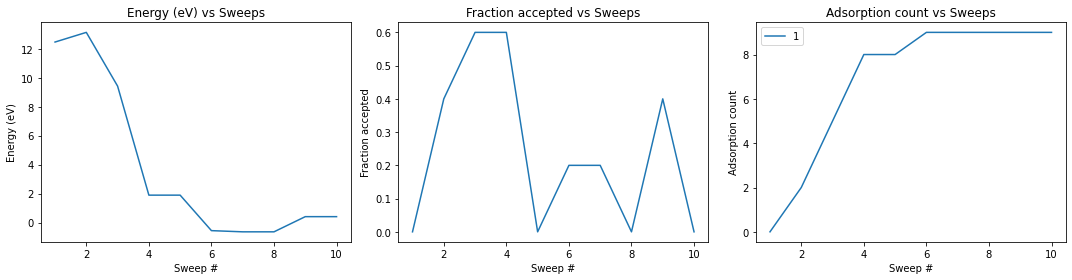

In [10]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=nff_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    offset=calc_settings["offset"],
    offset_data=calc_settings["offset_data"],
    optimizer=calc_settings["optimizer"],
)  # relax atoms with manual offset TODO fix this!

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [11]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)